In [1]:
import numpy as np
import pandas as pd
#import dask.dataframe as dd
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import seaborn as sns 
import requests
import re
from tqdm import tqdm

In [2]:
# chats = pd.read_parquet('../02_data/data_archive/raphaela/chats.parquet', engine='pyarrow')
# en_domain_stats = pd.read_parquet('../02_data/data_archive/raphaela/en_domain_stats.parquet', engine='pyarrow')
# chat_url_shares = np.load('../02_data/data_archive/raphaela/chat_url_shares.npz')
# urls = dd.read_parquet('../02_data/data_archive/raphaela/urls.parquet', engine = 'fastparquet') # , engine='pyarrow'

In [3]:
chats = pd.read_parquet('../02_data/chats.parquet', engine='pyarrow')
en_domain_stats = pd.read_parquet('../02_data/en_domain_stats.parquet', engine='pyarrow')
chat_url_shares = np.load('../02_data/chat_url_shares.npz')

In [4]:
urls = pd.read_parquet('../02_data/url.data.parquet', engine = 'fastparquet') # , engine='pyarrow'

In [5]:
urls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60789534 entries, 0 to 60789533
Data columns (total 16 columns):
 #   Column               Dtype         
---  ------               -----         
 0   index                int64         
 1   url                  object        
 2   domain               object        
 3   messages             int64         
 4   chats                int64         
 5   avalanches           int64         
 6   mean_avalanche_size  float64       
 7   top_avalanche_size   int64         
 8   virality             float64       
 9   top_shares_1h        int64         
 10  top_shares_6h        int64         
 11  top_shares_1d        int64         
 12  top_shares_3d        int64         
 13  top_shares_14d       int64         
 14  first_share_date     datetime64[ns]
 15  final_share_date     datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(10), object(2)
memory usage: 7.2+ GB


In [6]:
for url in urls["url"].head():
    print(url)

https://odysee.com/@jermwarfare:2/The-Baileys:8
https://drsambailey.com/its-elementary-my-dear-watson-unmasking-the-viral-paradigm/
https://drsambailey.com/why-nobody-had-caught-or-got-covid-19/
https://live.childrenshealthdefense.org/shows/good-morning-chd/qtpO5WHxFz
https://jonrappoport.substack.com/p/the-millionaire-blogger-in-the-land


### Extract Domain

In [7]:
# Function to extract the domain from a URL
def get_domain(url):
    try:
        parsed_url = urlparse(url)
        domain = parsed_url.netloc
        return domain if domain else None  
    except Exception:
        return None

# Add a new column with the domain extracted from the URL
urls['domain'] = urls['url'].apply(get_domain)

# Group by domain and count occurrences
domain_counts = urls['domain'].value_counts().reset_index()
domain_counts.columns = ['domain', 'frequency']

# Preview the result
print(domain_counts.head())

        domain  frequency
0  twitter.com    8405962
1         t.co    4973528
2       ift.tt    4104645
3     youtu.be    2185371
4         t.me    2024964


In [8]:
# Export
domain_counts.to_csv('../02_data/domain_counts.csv', index=False)

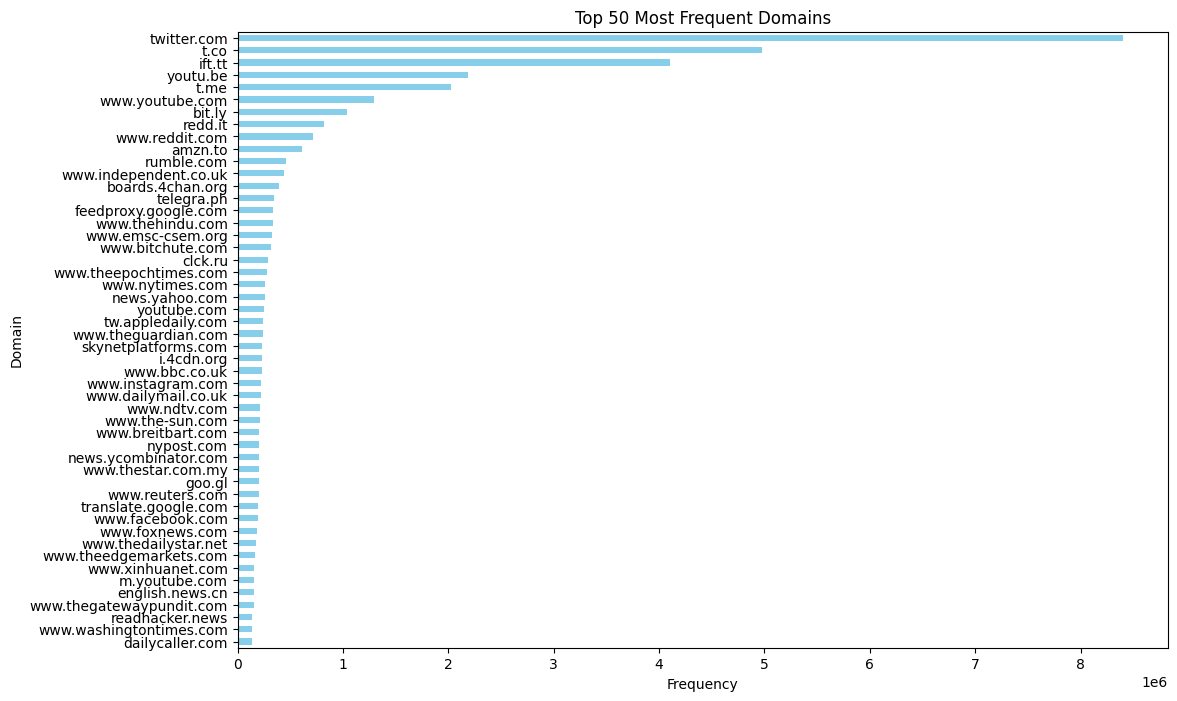

In [9]:
# Get the top 50 most frequent domains
top_domains = urls['domain'].value_counts().head(50)

# Plot the histogram
plt.figure(figsize=(12, 8))
top_domains.plot(kind='barh', color='skyblue')
plt.title('Top 50 Most Frequent Domains')
plt.xlabel('Frequency')
plt.ylabel('Domain')
plt.gca().invert_yaxis()  # Invert y-axis for better visualization
plt.show()

In [10]:
# Filter URLs that include "ift.tt"
ift_tt_urls = urls[urls['url'].str.contains("ift.tt", na=False)]

# Print a sample of the filtered URLs
print(ift_tt_urls.sample(5))  

             index                     url  domain  messages  chats  \
32398193  32398193  https://ift.tt/316vEBa  ift.tt         1      1   
60424607  60424607  https://ift.tt/bAM9yJS  ift.tt         1      1   
8201389    8201389  https://ift.tt/NgjnQkG  ift.tt         3      2   
52615752  52615752  https://ift.tt/b3986Qu  ift.tt        18      1   
21629443  21629443  https://ift.tt/MCo10vh  ift.tt         1      1   

          avalanches  mean_avalanche_size  top_avalanche_size  virality  \
32398193           1                  1.0                   1       1.0   
60424607           1                  1.0                   1       1.0   
8201389            1                  3.0                   3       1.0   
52615752           1                 18.0                  18       1.0   
21629443           1                  1.0                   1       1.0   

          top_shares_1h  top_shares_6h  top_shares_1d  top_shares_3d  \
32398193              1              1            

### Drop Social Media

In [11]:
social_media_domains = [
    'facebook.com', 'instagram.com', 'linkedin.com',
    'tiktok.com', 'snapchat.com',
    'youtube.com', 'youtu.be',  
    'twitter.com', 't.co', 't.me',
    'reddit.com', 'redd.it',
    'google.com', 'feedproxy.google.com', 'goo.gl',
    'bit.ly',
    # 'bit.ly', 'tinyurl.com', 'ow.ly', 'buff.ly', 'shorte.st', 'is.gd'
    'amzn.to', 'rumble.com', 'boards.4chan.org', '4chan.org',
    'telegra.ph', 'ift.tt' # ift.tt link compression 
]

# Function to check if a URL is from a social media site
def is_social_media(url):
    try:
        return any(domain in url for domain in social_media_domains)
    except:
        return None

tqdm.pandas()

# Filter out rows where the URL is from a social media site
urls_filtered = urls[~urls['url'].apply(is_social_media)]

# Check the cleaned DataFrame
print(urls_filtered.head())

num_social_media = len(urls) - len(urls_filtered)
print(f"Number of URLs filtered out: {num_social_media}")

   index                                                url  \
0      0    https://odysee.com/@jermwarfare:2/The-Baileys:8   
1      1  https://drsambailey.com/its-elementary-my-dear...   
2      2  https://drsambailey.com/why-nobody-had-caught-...   
3      3  https://live.childrenshealthdefense.org/shows/...   
4      4  https://jonrappoport.substack.com/p/the-millio...   

                            domain  messages  chats  avalanches  \
0                       odysee.com        11      9          10   
1                  drsambailey.com        18     14          13   
2                  drsambailey.com       104     71          59   
3  live.childrenshealthdefense.org        31     24          18   
4        jonrappoport.substack.com        24     20          14   

   mean_avalanche_size  top_avalanche_size  virality  top_shares_1h  \
0             1.100000                   2  0.327777              2   
1             1.384615                   4  0.323942              4   
2    

In [12]:
urls_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28117530 entries, 0 to 60789533
Data columns (total 16 columns):
 #   Column               Dtype         
---  ------               -----         
 0   index                int64         
 1   url                  object        
 2   domain               object        
 3   messages             int64         
 4   chats                int64         
 5   avalanches           int64         
 6   mean_avalanche_size  float64       
 7   top_avalanche_size   int64         
 8   virality             float64       
 9   top_shares_1h        int64         
 10  top_shares_6h        int64         
 11  top_shares_1d        int64         
 12  top_shares_3d        int64         
 13  top_shares_14d       int64         
 14  first_share_date     datetime64[ns]
 15  final_share_date     datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(10), object(2)
memory usage: 3.6+ GB


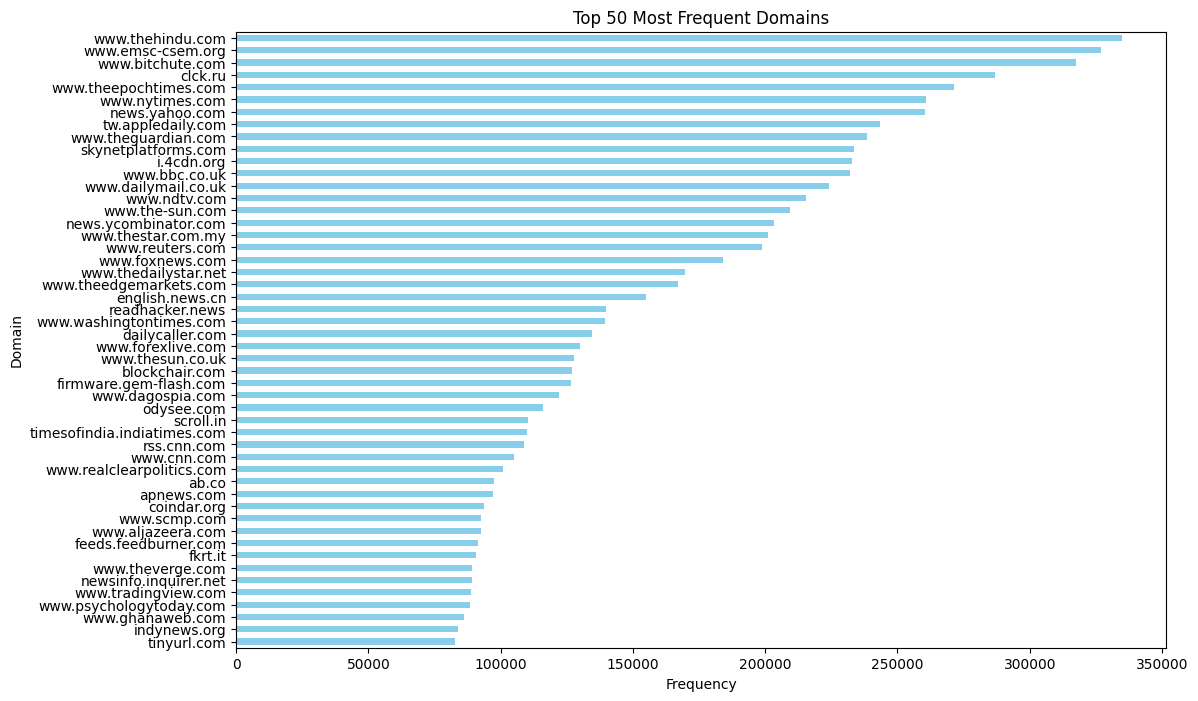

In [13]:
# Get the top 50 most frequent domains
top_domains = urls_filtered['domain'].value_counts().head(50)

# Plot the histogram
plt.figure(figsize=(12, 8))
top_domains.plot(kind='barh', color='skyblue')
plt.title('Top 50 Most Frequent Domains')
plt.xlabel('Frequency')
plt.ylabel('Domain')
plt.gca().invert_yaxis()  # Invert y-axis for better visualization
plt.show()

## filtering title from URL

In [14]:
# urls_sample = urls_filtered.sample(n=100000, random_state=42)

In [15]:
def extract_title(url):

    # Pattern to extract the title from the URL (assuming it's between slashes and hyphens)
    match = re.search(r'/([^/]+)/?$', url)  # Extract last part of URL after '/'
    if match:
        # Replace hyphens or underscores with spaces and return the title
        title = match.group(1).replace('-', ' ').replace('_', ' ')
        return title
    return None  

In [16]:
# tqdm.pandas()

# Apply the function to the 'url' column with a progress bar
# urls_filtered['title'] = urls_filtered['url'].progress_apply(extract_title)

In [17]:

# Display the DataFrame with titles
# print(urls_filtered)

### Filter non sense titles 

In [18]:
# import nltk
# from nltk.corpus import words
# nltk.download('words')

# english_words = set(words.words()) - {"a"}  # Exclude "a" from the set of English words

In [19]:
def contains_valid_word(title):
    # Check if title is not None
    if title is None:
        return False
    # Split the title into words and check if any are in the list of English words
    title_words = title.lower().split()
    return any(word in english_words for word in title_words)

In [20]:
# Filter the dataframe to include only titles with actual words
# urls_filtered = urls_filtered[urls_filtered['title'].apply(contains_valid_word)]

# print(urls_filtered.info())

Export Data

In [21]:
import os

# Save the DataFrame as a CSV file in the '02_data' folder
folder_path = "../02_data/"
csv_path = os.path.join(folder_path, 'url_sample_with_titles.csv')
urls_filtered.to_csv(csv_path, index=False)

In [22]:
# Compress and save the DataFrame as a .gz file
# csv_gz_path = os.path.join(folder_path, 'url_sample_with_titles.csv.gz')
# filtered_df.to_csv(csv_gz_path, index=False, compression='gzip')